### Анализ рынка коммерческой недвижимости Москвы и Московской области (площадь не менее 2000 кв. м, не дороже 300 млн руб.)

#### Сбор данных о коммерческой недвижимости Москвы и Московской области методом парсинга

Сайт - domofond.ru

Тип недвижимости - помещения свободного назначения, торговые площади, склады, офисы, здания, помещения под общепит, готовый бизнес, помещения под автосервисы, помещения под производства, помещения под бытовые услуги, гаражи и т.п.

In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup, SoupStrainer    
import requests
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Определение функции для парсинга
def domofond_parsing(min_area, max_price):
    """Cобирает характеристики и цены московской и подмосковной 
    коммерческой недвижимости с сайта domofond.ru
    arg min_area: минимальная площадь, кв. м,
    arg max_price: максимальная цена, руб."""
    df = pd.DataFrame()
    for p in range (1, 30):
        pages = []
        url = 'https://www.domofond.ru/prodazha-kommercheskay-nedvizhimost-moskovskaya_oblast-r81?PriceTo='+str(max_price)+'&FloorSizeFrom='+str(min_area)+'&Page='+str(p)
        response = requests.get(url)
        soup = BeautifulSoup(response.content, 'html.parser', parse_only=SoupStrainer('a', class_="long-item-card__item___ubItG search-results__itemCardNotFirst___3fei6"))
        urls = [link['href'] for link in soup if link.get('href')]
        pages += urls
        for page in pages:
            response = requests.get("https://www.domofond.ru"+page)   
            soup = BeautifulSoup(response.content, 'html.parser')
            try:
                name = soup.find(class_= "description__title___2N9Wk").text
            except:
                name = np.nan
            df.loc[df.shape[0], 'Наименование'] = name
            try:
                place = soup.find_all(class_="breadcrumbs__breadcrumb___onCIt")
                region = place[2].text
            except:
                region = np.nan
            df.loc[df.shape[0]-1, 'Регион'] = region
            if region == 'Москва':
                try:
                    place = soup.find_all(class_="breadcrumbs__breadcrumb___onCIt")
                    metro = place[4].text
                except:
                    metro = np.nan
                try:
                    place = soup.find(class_="area-rating__link___ZsnWR")['title']
                    pattern_3 = re.compile('.+[,]')
                    pattern_4 = re.compile('[,].+')
                    reg = pattern_3.findall(place)[0][:-1]
                    district = pattern_4.findall(place)[0][2:]
                except:
                    district = np.nan
                    reg = np.nan
            else:
                metro = np.nan
                district = np.nan
                reg = np.nan
            df.loc[df.shape[0]-1, 'Метро'] = metro
            df.loc[df.shape[0]-1, 'Округ'] = district
            df.loc[df.shape[0]-1, 'Район'] = reg
            if region == 'Московская область':
                place = soup.find_all(class_="breadcrumbs__breadcrumb___onCIt")
                try:
                    city = place[3].text
                except:
                    city = np.nan
            else:
                city = np.nan
            df.loc[df.shape[0]-1, 'Городской округ МО'] = city
            information = soup.find_all('div', class_="detail-information__row___29Fu6")
            info = []
            for i in range(len(information)):
                info.append(information[i].text)
            pattern = re.compile('[А-Я][а-я]*\W')
            info_dict = {}
            for item in info:
                pattern_1 = re.compile('.+[:]')
                pattern_2 = re.compile('[:].+')
                info_key = pattern_1.findall(item)[0][:-1]
                info_value = pattern_2.findall(item)[0][2:]
                if info_value == '': info_value = np.nan
                info_dict[info_key] = info_value
            for item in info_dict.items():
                df.loc[df.shape[0]-1, item[0]] = item[1]       
            try:
                address = soup.find(class_="location__text___bhjoZ").text
            except:
                address = np.nan
            df.loc[df.shape[0]-1, 'Адрес'] = address
            df.loc[df.shape[0]-1, 'Ссылка'] = "https://www.domofond.ru"+page
            try:
                description = soup.find(class_= "description__description___2FDOM").text
            except:
                description = np.nan
            df.loc[df.shape[0]-1, 'Описание'] = description
    print('Парсинг завершен. Количество объектов недвижимости - ', df.shape[0])
    return df

##### Сбор информации о коммерческой недвжимости площадью не менее 2000 кв. метров и стоимостью не дороже 300 млн. руб.

In [3]:
# парсинг
df_parsing = domofond_parsing(2000, 300000000)

Парсинг завершен. Количество объектов недвижимости -  754


In [4]:
# сохранение данных
df_parsing.to_csv('df_parsing.csv', index = False)

##### Обработка собранных данных


In [3]:
df = pd.read_csv('df_parsing.csv')

In [4]:
df.head()

,Наименование,Регион,Метро,Округ,Район,Городской округ МО,Тип,Класс здания,Площадь,Цена,Цена за м²,Тип объекта,Дата публикации объявления,Дата обновления объявления,Номер в каталоге,Адрес,Ссылка,Описание
0,"Офис, 7500 м²",Москва,Площадь Ильича,ЦАО,Таганский,NaN,Коммерческая недвижимость,NaN,7500 м²,149 000 000 ₽,19 867 ₽,Офис,16/6/2020,19/8/2020,2.644715e+09,"Москва, Волочаевская улица, 11/15с1, Таганский...",https://www.domofond.ru/kommercheskayanedvizhi...,"Здание Дома культуры ""Серп и Молот"" (залы с вы..."
1,"Офис, 2350 м²",Московская область,NaN,NaN,NaN,Лобня,Коммерческая недвижимость,B,2350 м²,60 000 000 ₽,25 532 ₽,Офис,14/7/2020,19/8/2020,2.714703e+09,"Московская область, Лобня, улица Ленина, 37, Л...",https://www.domofond.ru/kommercheskayanedvizhi...,"Продажа здания, общей площадью 2 347,9 кв.м, З..."
2,"Магазин, 5022 м²",Москва,Окружная,СВАО,Марфино,NaN,Коммерческая недвижимость,NaN,5022 м²,273 000 000 ₽,54 361 ₽,Магазин,12/12/2016,18/8/2020,1.753862e+08,"Москва, Гостиничная улица, 10Вс1, Марфино, Москва",https://www.domofond.ru/kommercheskayanedvizhi...,Продается многофункциональное здание общей пло...
3,"Производство, 7646 м²",Московская область,NaN,NaN,NaN,Подольск,Коммерческая недвижимость,NaN,7646 м²,133 000 000 ₽,17 395 ₽,Производство,28/5/2018,18/8/2020,2.540810e+08,"Московская область, Подольск, Большая Серпухов...",https://www.domofond.ru/kommercheskayanedvizhi...,Собственник продает производственно- офисный к...
4,"Коммерческая недвижимость, 18144 м²",Московская область,NaN,NaN,NaN,Сергиев Посад,Коммерческая недвижимость,NaN,18144 м²,11 861 952 ₽,654 ₽,Коммерческая недвижимость,13/8/2020,22/8/2020,2.786289e+09,"Московская область, Сергиев Посад, микрорайон ...",https://www.domofond.ru/kommercheskayanedvizhi...,"Объекты недвижимости, расположенные на земельн..."


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 754 entries, 0 to 753
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Наименование                739 non-null    object 
 1   Регион                      754 non-null    object 
 2   Метро                       265 non-null    object 
 3   Округ                       235 non-null    object 
 4   Район                       235 non-null    object 
 5   Городской округ МО          489 non-null    object 
 6   Тип                         739 non-null    object 
 7   Класс здания                80 non-null     object 
 8   Площадь                     739 non-null    object 
 9   Цена                        739 non-null    object 
 10  Цена за м²                  739 non-null    object 
 11  Тип объекта                 739 non-null    object 
 12  Дата публикации объявления  739 non-null    object 
 13  Дата обновления объявления  739 non

In [6]:
df = pd.read_csv('df_parsing.csv')

In [7]:
df['Дата публикации объявления'] = pd.to_datetime(df['Дата публикации объявления'])
df['Дата обновления объявления'] = pd.to_datetime(df['Дата обновления объявления'])

In [8]:
df['Цена, руб.'] = df['Цена'].apply(lambda x: float(x.replace('₽', '').replace(' ', '')) if type(x) == str else x)

In [9]:
df.drop('Цена', axis = 1, inplace = True)

In [10]:
df['Площадь, кв. м'] = df['Площадь'].apply(lambda x: float(x[:-3]) if type(x) == str else x)

In [11]:
df.drop('Площадь', axis = 1, inplace = True)

In [12]:
df.dropna(subset = ['Цена, руб.', 'Площадь, кв. м'], inplace = True)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 739 entries, 0 to 752
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Наименование                739 non-null    object        
 1   Регион                      739 non-null    object        
 2   Метро                       260 non-null    object        
 3   Округ                       235 non-null    object        
 4   Район                       235 non-null    object        
 5   Городской округ МО          479 non-null    object        
 6   Тип                         739 non-null    object        
 7   Класс здания                80 non-null     object        
 8   Цена за м²                  739 non-null    object        
 9   Тип объекта                 739 non-null    object        
 10  Дата публикации объявления  739 non-null    datetime64[ns]
 11  Дата обновления объявления  739 non-null    datetime64[ns]

##### Разведочный анализ данных

Text(0, 0.5, 'Количество предложений')

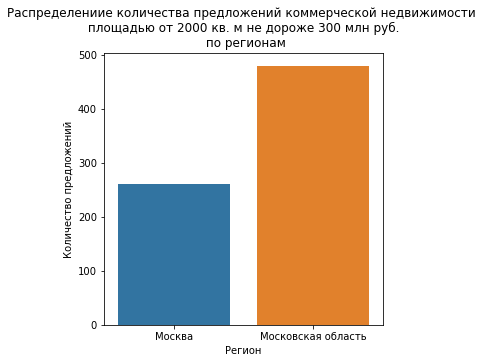

In [14]:
fig, ax = plt.subplots(figsize=(5,5)) 
sns.countplot(x = 'Регион', data = df)
ax.set_title('Распределениие количества предложений коммерческой недвижимости \n площадью от 2000 кв. м не дороже 300 млн руб. \n по регионам')
ax.set_xlabel('Регион')
ax.set_ylabel('Количество предложений')

2/3 предложений приходятся на Московскую область.

Рассмотрим аналогичное распределение с учетом типов объектов:

Text(0, 0.5, 'Количество предложений')

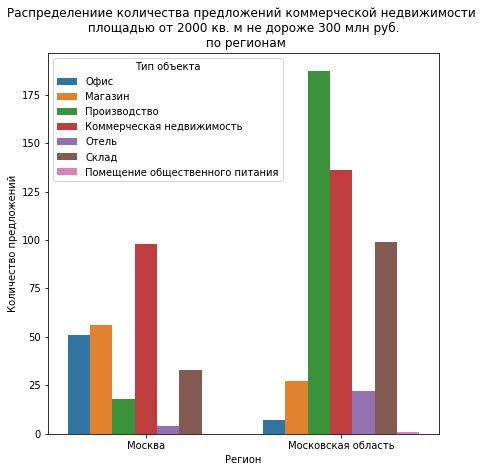

In [15]:
fig, ax = plt.subplots(figsize=(7, 7)) 
sns.countplot(x = 'Регион', hue = 'Тип объекта', data = df)
ax.set_title('Распределениие количества предложений коммерческой недвижимости \n площадью от 2000 кв. м не дороже 300 млн руб. \n по регионам')
ax.set_xlabel('Регион')
ax.set_ylabel('Количество предложений')

В Московской области продаются в основном производства и склады, в Москве - офисы и магазины. 

Text(0.5, 1.0, 'Распределение предложений по площади')

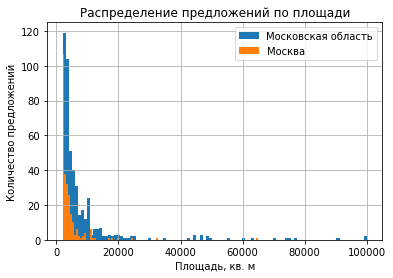

In [16]:
df[df['Регион'] == 'Московская область']['Площадь, кв. м'].hist(bins = 100)
df[df['Регион'] == 'Москва']['Площадь, кв. м'].hist(bins = 100)
plt.xlabel('Площадь, кв. м')
plt.ylabel('Количество предложений')
plt.legend(('Московская область', 'Москва'))
plt.title('Распределение предложений по площади')

Подавлюящее большинство продаваемой недвижимости имеет площадь до 10000 кв. м. 

Text(0.5, 1.0, 'Средння площадь')

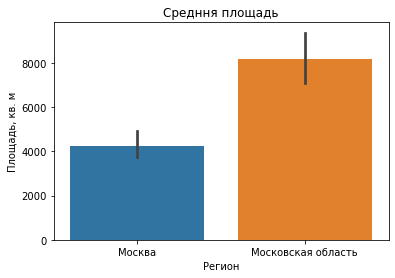

In [17]:
sns.barplot("Регион", "Площадь, кв. м", data=df).set_title('Средння площадь')

При этом средння площадь недвижимости, выставленной на продажу в Москве, приблизительно в 2 раза меньше средней площади подмосковной недвжижимости.

Text(0.5, 1.0, 'Средння площадь')

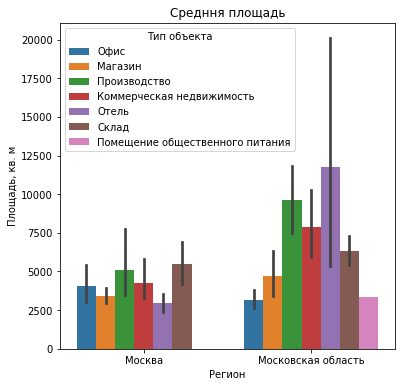

In [18]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.barplot("Регион", "Площадь, кв. м", hue = 'Тип объекта', data=df).set_title('Средння площадь')

При этом самая большая площадь характерна для отелей в Москве и для складов в Московской области. 

Text(0.5, 1.0, 'Распределение предложений по цене')

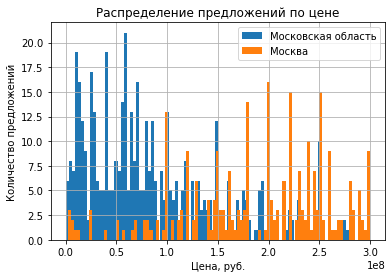

In [19]:
df[df['Регион'] == 'Московская область']['Цена, руб.'].hist(bins = 100)
df[df['Регион'] == 'Москва']['Цена, руб.'].hist(bins = 100)
plt.xlabel('Цена, руб.')
plt.ylabel('Количество предложений')
plt.legend(('Московская область', 'Москва'))
plt.title('Распределение предложений по цене')

Text(0.5, 1.0, 'Средняя цена')

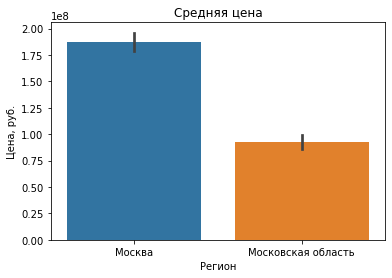

In [20]:
sns.barplot("Регион", "Цена, руб.", data=df).set_title('Средняя цена')

С ценой ситуация обратная. Средняя стоимость московской недвжимости более, чем в 2 раза, певышает стоимость подмосковой недвжимости. Рассмотрим более подробно распределение средних цен в зависимости от типа объекта:

Text(0.5, 1.0, 'Средняя цена')

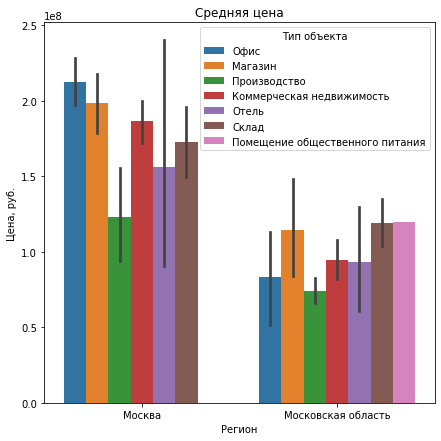

In [21]:
fig, ax = plt.subplots(figsize=(7, 7))
sns.barplot("Регион", "Цена, руб.", hue = 'Тип объекта', data=df).set_title('Средняя цена')

Рассмотрим ситуацию по округам Москвы:

Text(0, 0.5, 'Количество предложений')

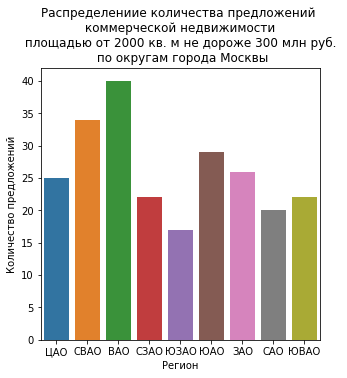

In [22]:
fig, ax = plt.subplots(figsize=(5,5)) 
sns.countplot(x = 'Округ', data = df[df['Регион'] == 'Москва'])
ax.set_title('Распределениие количества предложений \n коммерческой недвижимости \n площадью от 2000 кв. м не дороже 300 млн руб. \n по округам города Москвы')
ax.set_xlabel('Регион')
ax.set_ylabel('Количество предложений')

Распределение количество предложений по Москве показывает, что наибольшее количество предложений продажи приходится на ВАО, наименьшее - на ЮЗАО. 

Text(0.5, 1.0, 'Средння площадь недвижимости по округам. г. Москвы')

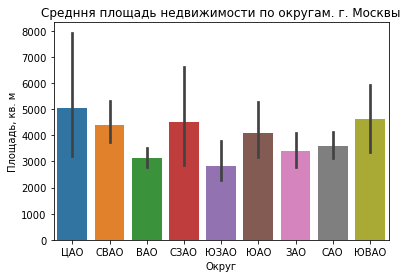

In [23]:
sns.barplot("Округ", "Площадь, кв. м", data=df[df['Регион'] == 'Москва']).set_title('Средння площадь недвижимости по округам. г. Москвы')

Text(0.5, 1.0, 'Средння цена недвижимости \n по округам. г. Москвы')

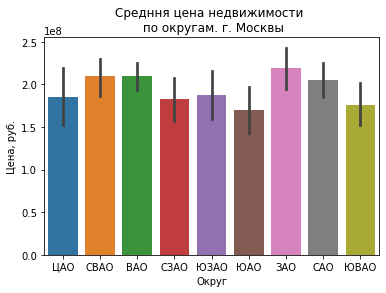

In [24]:
sns.barplot("Округ", "Цена, руб.", data=df[df['Регион'] == 'Москва']).set_title('Средння цена недвижимости \n по округам. г. Москвы')

Наибольшая средння цена коммерческой недвижимости характерана для ЗАО - более 200 млн. руб. При этом в ЦАО и ЮЗАО средняя цена коммерческой недвижимости меньше, чем в САО, СВАО, ВАО.

##### Зависимость цены объекта от площади (Москва)

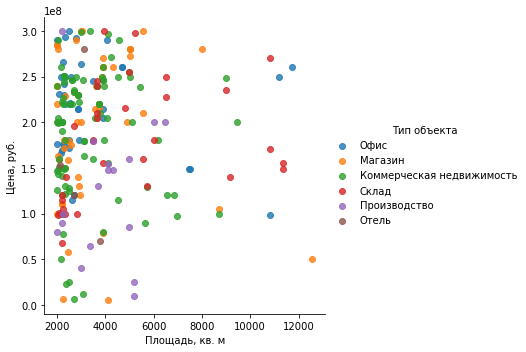

In [25]:
sns.lmplot(x='Площадь, кв. м', y='Цена, руб.', hue='Тип объекта', data=df[(df['Регион'] == 'Москва') & (df['Площадь, кв. м'] < 15000)], fit_reg=False)

##### Зависимость цены объекта от площади (Московская область)

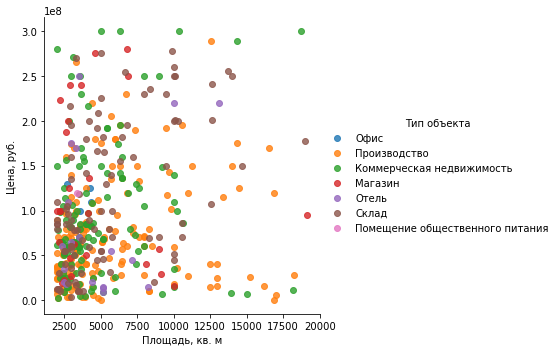

In [26]:
sns.lmplot(x='Площадь, кв. м', y='Цена, руб.', hue='Тип объекта', data=df[(df['Регион'] == 'Московская область') & (df['Площадь, кв. м'] < 20000)], fit_reg=False)

Рассмотрим зависимость более подробно для каждого типа помещений:

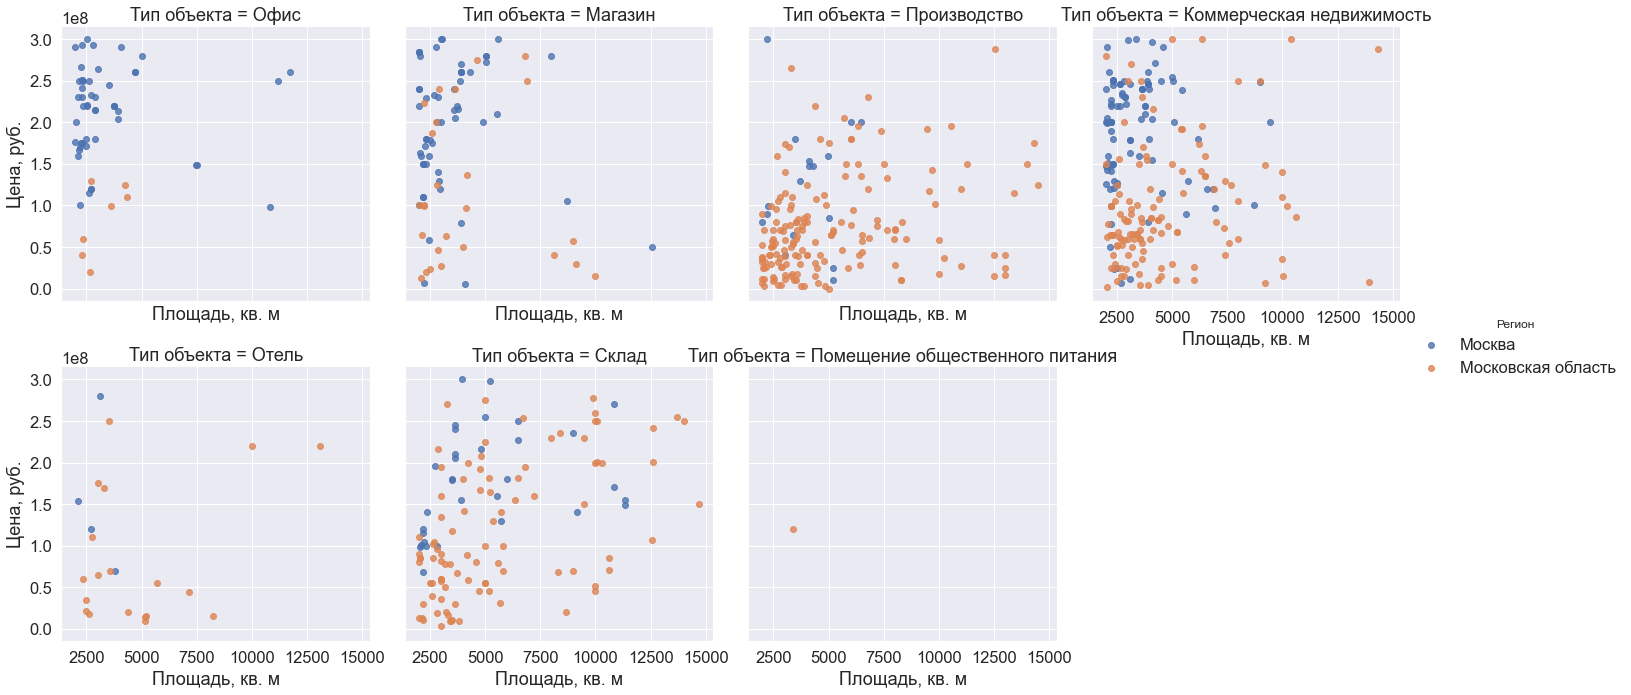

In [27]:
sns.set(font_scale=1.5)
sns.lmplot('Площадь, кв. м', 'Цена, руб.', data=df[df['Площадь, кв. м'] < 15000], 
           hue = 'Регион', col = 'Тип объекта', fit_reg=False, col_wrap = 4, height = 5).set(xlabel = 'Площадь, кв. м')

Четкой корреляции между площадью помещений различных типов и их ценой не наблюдается как для Москвы, так и для Московской области. По-видимому, на цену сильнее влияют другие факторы. 